In [1]:
from helper import *
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.autograd as autograd
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
# import torchvision
# import torchvision.transforms as transforms
import random
# import pdb
import numpy as np
import math
import re
import os

In [2]:
class VidNet(nn.Module):
    def __init__(self,method,num_classes,input_features,classifier_size,timesteps_vid):
        super(VidNet, self).__init__()
#         self.num_timesteps = num_timesteps
        self.timesteps_vid = timesteps_vid
        self.method = method
        self.num_classes = num_classes
        self.input_features = input_features
        self.classifier_size = classifier_size
        if self.method=='slow':
            self.mult1 = (self.timesteps_vid//4)//2
            self.mult2 = 2
        else:
            self.mult1 = 1
            self.mult2 = 1
        
        self.layers = nn.Sequential(
            # in, out, stride, padding
            # in, out, stride, padding
            nn.Conv2d(self.input_features,96,11,stride = 3,padding = 2),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            nn.Dropout(.25),
            nn.Conv2d(96*self.mult1,256,5,stride = 1,padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            nn.Dropout(.25),
            nn.Conv2d(256*self.mult2,384*self.mult2,3,stride = 1,padding=2),
            nn.Conv2d(384*self.mult2,384,3,stride = 1,padding=2),
            nn.Conv2d(384,256,3,stride = 1,padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3,2))
        self.classifiers =nn.Sequential(
            nn.Linear(9216*classifier_size,4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096,4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096,self.num_classes)
#             nn.Softmax() # maybe make delete this and try F.log_softmax() in forward
            )
    def forward(self,inputs):
        if self.method == 'single' or self.method =='early' or self.method == 'conv_pool':
            x = inputs
            for layer in self.layers:
                x = layer(x)

        elif self.method == 'late':
            x = torch.Tensor(0,0)
            for xind in range(inputs.size(1)):
                
                xin = inputs[:,xind,:,:].unsqueeze(1)
                
            # x1,x2 = input
                for layer in self.layers:
                    xin = layer(xin)
                x = torch.cat((x,xin),1)
        
        elif self.method == 'slow':
            self.cmult=self.input_features

            x = torch.Tensor(0,0)
            xout = torch.Tensor(0,0)
            for xind in np.arange(0,inputs.size(1),self.cmult):
#                 import pdb; pdb.set_trace()
                xin = inputs[:,xind:xind+self.cmult,:,:]
            # x1,x2,x3,x4 = input
                for layer in self.layers[0:5]:
                    xin = layer(xin)
                xout = torch.cat((xout,xin),1)
            xa = xout[:,:int(xout.shape[1]/2),:,:]
            xb = xout[:,int(xout.shape[1]/2):,:,:]
            for layer in self.layers[5:10]:
                xa = layer(xa)
                xb = layer(xb)
            x = torch.cat((xa,xb),1)
            for layer in self.layers[10:]:
                x = layer(x)

        else:
            print('Define Method')
            x = inputs
#             break

        for classifier in self.classifiers:
            x = x.view(x.size(0),-1)
            x = classifier(x)
        x = F.log_softmax(x)
        return x

In [3]:
class Trainer():
    def __init__(self,net,dic,datapath,timesteps,epochs,
                 optimizer,criterion,batch_size,color,random_sample,skip):
        self.datapath = datapath
        self.method = method
        self.epochs = epochs
        self.optimizer = optimizer
        self.criterion = criterion
        self.timesteps = timesteps
        self.net = net
        self.batch_size = batch_size
        self.color = color
        self.random_sample = random_sample
        self.skip = skip
        self.dic = dic

    def get_accuracy(self,outputs,labels):
        _, predicted = torch.max(outputs.data, 1)
        correct = float(((predicted == labels.detach()).sum()).item())
        total = labels.size(0)
        return correct, total

    def train_test(self,path,train):
        loss_vec = []
        acc_vec = []
        # net = VidNet(self.timesteps,self.method)
#         content_t = []
        paths = os.listdir(path)
        pt_test = paths[::4]
        pt_train = list(set(paths) - set(pt_test))
        if train:
            paths = pt_train
        else:
            paths = pt_test
#         random.shuffle(paths)
        labels = [re.findall('_([^_]*)_', datastr)[0] for datastr in paths]
#         x = list(set(labels))
#         dic = dict(zip(x, list(range(0,len(x)))))
        num_labels = [self.dic[v] for v in labels]

#         paths = [re.findall('"([^"]*)"', c)[0] for c in content_t]
        running_loss = 0
        correct = 0
        total = 0
        for bs in range(self.batch_size):
            b_targets = num_labels[bs*self.batch_size:(bs*self.batch_size)+self.batch_size]
            b_path = paths[bs*self.batch_size:(bs*self.batch_size)+self.batch_size]
            frame_array=[]
            # import pdb; pdb.set_trace()
            flpts_array = []
            for vid_name in b_path:
                if vid_name[0]=='.':
                    vid_name = vid_name[2:]
                frame_array.append(torch.Tensor(np.array(video3d(self.datapath + vid_name, (110,110,self.timesteps),color=self.color,skip=self.skip,rand=self.random_sample))))
#             import pdb; pdb.set_trace()
            torch_frames = torch.cat(frame_array,0)
            self.optimizer.zero_grad()
            outputs = self.net(torch_frames)
            targets = torch.LongTensor(b_targets)
            loss = self.criterion(outputs, targets)
#             import pdb; pdb.set_trace()
            if train:
                loss.backward()
                self.optimizer.step()
            running_loss += loss.detach().numpy()
#             import pdb; pdb.set_trace()
            correct_i, total_i = self.get_accuracy(outputs, targets)
            correct += correct_i
            total += total_i
#         import pdb; pdb.set_trace()
        loss_vec.append(running_loss/(len(labels))/self.batch_size)
        acc_vec.append(correct/total)
        return loss_vec, acc_vec
    
    def run_epochs(self,save_name):
        e_train_loss = []
        e_train_acc = []
        e_test_loss = []
        e_test_acc = []
        for i in range(self.epochs):
            train_loss, train_acc = self.train_test(self.datapath, train=True)
            test_loss, test_acc = self.train_test(self.datapath, train=False)
            e_train_loss.append(train_loss)
            e_test_loss.append(test_loss)
            e_train_acc.append(train_acc)
            e_test_acc.append(test_acc)
            torch.save(self.net.state_dict(),save_name + '.pt')
            torch.save(self.optimizer.state_dict(),save_name + '_opt.pt')
            with open(save_name + '_trainloss.csv','a') as f:
                f.write(str(train_loss))
            with open(save_name + '_trainacc.csv','a') as f:
                f.write(str(train_acc))
            with open(save_name + '_testloss.csv','a') as f:
                f.write(str(test_loss))
            with open(save_name + '_testacc.csv','a') as f:
                f.write(str(test_acc))
            print('Epoch ' + str(i) + ':  Train Loss: ' + str(train_loss) + '; Test Loss: ' + str (test_loss))
            print('Epoch ' + str(i) + ':  Train Accuracy: ' + str(train_acc) + '; Test Accuracy: ' + str (test_acc))
        return e_train_loss, e_test_loss, e_train_acc, e_test_acc



/Users/jenniferdawkins/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 0:  Train Loss: [0.004029369513547766]; Test Loss: [0.011875856240590413]
Epoch 0:  Train Accuracy: [0.15]; Test Accuracy: [0.21]
Epoch 1:  Train Loss: [0.003861315053927075]; Test Loss: [0.011469432671864828]
Epoch 1:  Train Accuracy: [0.25]; Test Accuracy: [0.18]
Epoch 2:  Train Loss: [0.0037232861221500385]; Test Loss: [0.010108195543289185]
Epoch 2:  Train Accuracy: [0.2]; Test Accuracy: [0.38]
Epoch 3:  Train Loss: [0.0031722488010381008]; Test Loss: [0.008321937561035156]
Epoch 3:  Train Accuracy: [0.37]; Test Accuracy: [0.33]
Epoch 4:  Train Loss: [0.0028206615511717935]; Test Loss: [0.008516250451405843]
Epoch 4:  Train Accuracy: [0.35]; Test Accuracy: [0.35]
Epoch 5:  Train Loss: [0.0026918423998860313]; Test Loss: [0.00771502415339152]
Epoch 5:  Train Accuracy: [0.35]; Test Accuracy: [0.37]
Epoch 6:  Train Loss: [0.002705047762473601]; Test Loss: [0.008465089718500773]
Epoch 6:  Train Accuracy: [0.37]; Test Accuracy: [0.32]
Epoch 7:  Train Loss: [0.002600860622253078]; 

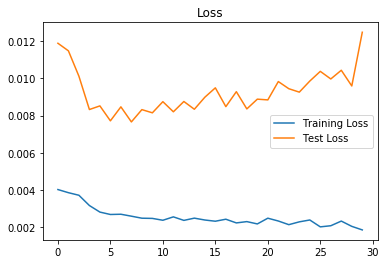

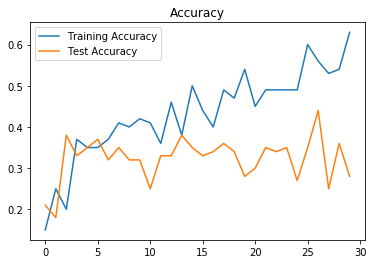

In [14]:
base_path = 'VideoData/'
method = 'conv_pool'
num_epochs = 30
torch.set_default_tensor_type('torch.FloatTensor')
color = False
random_sample = True
skip = True
load = False
save_name = 'NEW_DATA_convpool_rand_noskip_nocol'
# best LR: .0001
# best weight_decay: .005
# best weight_decay: .005
paths = os.listdir(base_path)
labels = [re.findall('_([^_]*)_', datastr)[0] for datastr in paths]
x = list(set(labels))
dic = dict(zip(x, list(range(0,len(x)))))
if color:
    input_features = 3
else:
    input_features = 1
    
if method == 'single':
    timesteps_vid = 1
    timesteps_net = 1
    net = VidNet(method,6,input_features*timesteps_net,timesteps_vid,timesteps_vid)
elif method=='conv_pool':
    timesteps_vid = 16
    timesteps_net = 16
    net = VidNet(method,6,input_features*timesteps_net,1,timesteps_vid)
elif method == 'late':
    timesteps_vid = 4
    timesteps_net = 1
    net = VidNet(method,6,input_features*timesteps_net,timesteps_vid,timesteps_vid)
elif method == 'slow':
    timesteps_vid = 16
    timesteps_net = 4
    net = VidNet(method,6,input_features*timesteps_net,1,timesteps_vid)
else:
    print('define valid method')
if load:
    net.load_state_dict(torch.load(save_name + '.pt'))
    net.cuda()
    print(next(net.parameters()).is_cuda)
#     for statet in net.state.values():
#         for h,g in statet.items():
#             if torch.is_tensor(g):
#                 statet[h] = g.cuda()
    optimize = optim.Adam(net.parameters(), lr = 0.0001, weight_decay = .005)
    optimize.load_state_dict(torch.load(save_name + '_opt.pt'))
    for state in optimize.state.values():
        for k, v in state.items():
            if torch.is_tensor(v):
                state[k] = v.cuda()
else:
    optimize = optim.Adam(net.parameters(), lr = 0.0001, weight_decay = .005)
#     net.cuda()
crit = nn.CrossEntropyLoss()
#(self,net,train_path,test_path,vid_path,epochs,optimizer,criterion)
tr = Trainer(net,dic,base_path,timesteps_vid,num_epochs,optimize,crit,10,color,
                random_sample,skip)
trl,tstl,tra,tsta = tr.run_epochs(save_name)

plt.figure()
plt.plot(range(num_epochs),trl,label= 'Training Loss')
plt.plot(range(num_epochs),tstl,label= 'Test Loss')
plt.legend()
plt.title('Loss')
plt.show()

plt.figure()
plt.plot(range(num_epochs),tra,label= 'Training Accuracy')
plt.plot(range(num_epochs),tsta,label= 'Test Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

/Users/jenniferdawkins/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 0:  Train Loss: [0.0041352061758062626]; Test Loss: [0.01190817419687907]
Epoch 0:  Train Accuracy: [0.13]; Test Accuracy: [0.2]
Epoch 1:  Train Loss: [0.0038984407029863458]; Test Loss: [0.011877930959065756]
Epoch 1:  Train Accuracy: [0.23]; Test Accuracy: [0.18]
Epoch 2:  Train Loss: [0.003831755929110045]; Test Loss: [0.01105045747756958]
Epoch 2:  Train Accuracy: [0.24]; Test Accuracy: [0.25]
Epoch 3:  Train Loss: [0.0032573780663029384]; Test Loss: [0.011663759390513102]
Epoch 3:  Train Accuracy: [0.32]; Test Accuracy: [0.35]
Epoch 4:  Train Loss: [0.0032255924358665275]; Test Loss: [0.008874216636021932]
Epoch 4:  Train Accuracy: [0.36]; Test Accuracy: [0.33]
Epoch 5:  Train Loss: [0.0027285792779816282]; Test Loss: [0.008936533689498902]
Epoch 5:  Train Accuracy: [0.36]; Test Accuracy: [0.32]
Epoch 6:  Train Loss: [0.002968967584830881]; Test Loss: [0.008328030109405518]
Epoch 6:  Train Accuracy: [0.31]; Test Accuracy: [0.3]
Epoch 7:  Train Loss: [0.0026272471073210107]; 

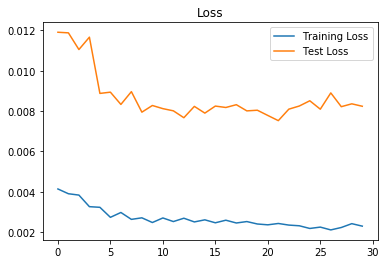

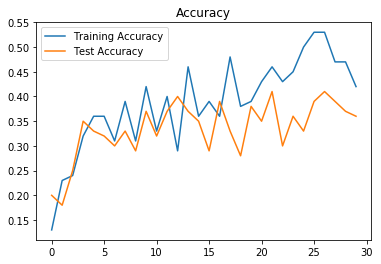

In [18]:
save_name = 'NEW_DATA_late_rand_noskip_nocol'
method = 'late'
base_path = 'VideoData/'
num_epochs = 30
torch.set_default_tensor_type('torch.FloatTensor')
color = False
random_sample = True
skip = True
load = False
# best LR: .0001
# best weight_decay: .005
# best weight_decay: .005
paths = os.listdir(base_path)
labels = [re.findall('_([^_]*)_', datastr)[0] for datastr in paths]
x = list(set(labels))
dic = dict(zip(x, list(range(0,len(x)))))
if color:
    input_features = 3
else:
    input_features = 1
    
if method == 'single':
    timesteps_vid = 1
    timesteps_net = 1
    net = VidNet(method,6,input_features*timesteps_net,timesteps_vid,timesteps_vid)
elif method=='conv_pool':
    timesteps_vid = 16
    timesteps_net = 16
    net = VidNet(method,6,input_features*timesteps_net,1,timesteps_vid)
elif method == 'late':
    timesteps_vid = 4
    timesteps_net = 1
    net = VidNet(method,6,input_features*timesteps_net,timesteps_vid,timesteps_vid)
elif method == 'slow':
    timesteps_vid = 16
    timesteps_net = 4
    net = VidNet(method,6,input_features*timesteps_net,1,timesteps_vid)
else:
    print('define valid method')
if load:
    net.load_state_dict(torch.load(save_name + '.pt'))
    net.cuda()
    print(next(net.parameters()).is_cuda)
#     for statet in net.state.values():
#         for h,g in statet.items():
#             if torch.is_tensor(g):
#                 statet[h] = g.cuda()
    optimize = optim.Adam(net.parameters(), lr = 0.0001, weight_decay = .005)
    optimize.load_state_dict(torch.load(save_name + '_opt.pt'))
    for state in optimize.state.values():
        for k, v in state.items():
            if torch.is_tensor(v):
                state[k] = v.cuda()
else:
    optimize = optim.Adam(net.parameters(), lr = 0.0001, weight_decay = .005)
#     net.cuda()
crit = nn.CrossEntropyLoss()
#(self,net,train_path,test_path,vid_path,epochs,optimizer,criterion)
tr = Trainer(net,dic,base_path,timesteps_vid,num_epochs,optimize,crit,10,color,
                random_sample,skip)
trl,tstl,tra,tsta = tr.run_epochs(save_name)

plt.figure()
plt.plot(range(num_epochs),trl,label= 'Training Loss')
plt.plot(range(num_epochs),tstl,label= 'Test Loss')
plt.legend()
plt.title('Loss')
plt.show()

plt.figure()
plt.plot(range(num_epochs),tra,label= 'Training Accuracy')
plt.plot(range(num_epochs),tsta,label= 'Test Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

/Users/jenniferdawkins/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 0:  Train Loss: [0.004010514666083661]; Test Loss: [0.011734421730041505]
Epoch 0:  Train Accuracy: [0.18]; Test Accuracy: [0.21]
Epoch 1:  Train Loss: [0.0038741745768251824]; Test Loss: [0.01054914704958598]
Epoch 1:  Train Accuracy: [0.18]; Test Accuracy: [0.27]
Epoch 2:  Train Loss: [0.003402697084210232]; Test Loss: [0.008589794635772705]
Epoch 2:  Train Accuracy: [0.29]; Test Accuracy: [0.3]
Epoch 3:  Train Loss: [0.002987796081466505]; Test Loss: [0.00877388366063436]
Epoch 3:  Train Accuracy: [0.22]; Test Accuracy: [0.35]
Epoch 4:  Train Loss: [0.002784179220751824]; Test Loss: [0.008050658305486043]
Epoch 4:  Train Accuracy: [0.37]; Test Accuracy: [0.34]
Epoch 5:  Train Loss: [0.002725358768667038]; Test Loss: [0.008166974186897278]
Epoch 5:  Train Accuracy: [0.33]; Test Accuracy: [0.32]
Epoch 6:  Train Loss: [0.0024759110469860595]; Test Loss: [0.008831009387969971]
Epoch 6:  Train Accuracy: [0.38]; Test Accuracy: [0.32]
Epoch 7:  Train Loss: [0.002568203502880173]; Tes

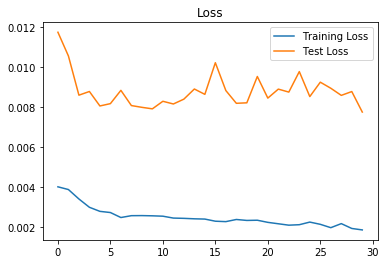

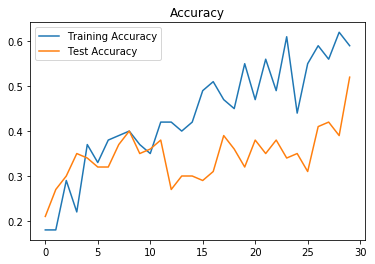

In [19]:
method = 'slow'
save_name = 'slow_rand_skip_nocol'
# best LR: .0001
# best weight_decay: .005
color = False
random_sample = True
skip = True
load = False

base_path = 'VideoData/'
num_epochs = 30
torch.set_default_tensor_type('torch.FloatTensor')
# best LR: .0001
# best weight_decay: .005
# best weight_decay: .005
paths = os.listdir(base_path)
labels = [re.findall('_([^_]*)_', datastr)[0] for datastr in paths]
x = list(set(labels))
dic = dict(zip(x, list(range(0,len(x)))))
if color:
    input_features = 3
else:
    input_features = 1
    
if method == 'single':
    timesteps_vid = 1
    timesteps_net = 1
    net = VidNet(method,6,input_features*timesteps_net,timesteps_vid,timesteps_vid)
elif method=='conv_pool':
    timesteps_vid = 16
    timesteps_net = 16
    net = VidNet(method,6,input_features*timesteps_net,1,timesteps_vid)
elif method == 'late':
    timesteps_vid = 4
    timesteps_net = 1
    net = VidNet(method,6,input_features*timesteps_net,timesteps_vid,timesteps_vid)
elif method == 'slow':
    timesteps_vid = 16
    timesteps_net = 4
    net = VidNet(method,6,input_features*timesteps_net,1,timesteps_vid)
else:
    print('define valid method')
if load:
    net.load_state_dict(torch.load(save_name + '.pt'))
    net.cuda()
    print(next(net.parameters()).is_cuda)
#     for statet in net.state.values():
#         for h,g in statet.items():
#             if torch.is_tensor(g):
#                 statet[h] = g.cuda()
    optimize = optim.Adam(net.parameters(), lr = 0.0001, weight_decay = .005)
    optimize.load_state_dict(torch.load(save_name + '_opt.pt'))
    for state in optimize.state.values():
        for k, v in state.items():
            if torch.is_tensor(v):
                state[k] = v.cuda()
else:
    optimize = optim.Adam(net.parameters(), lr = 0.0001, weight_decay = .005)
#     net.cuda()
crit = nn.CrossEntropyLoss()
#(self,net,train_path,test_path,vid_path,epochs,optimizer,criterion)
tr = Trainer(net,dic,base_path,timesteps_vid,num_epochs,optimize,crit,10,color,
                random_sample,skip)
trl,tstl,tra,tsta = tr.run_epochs(save_name)

plt.figure()
plt.plot(range(num_epochs),trl,label= 'Training Loss')
plt.plot(range(num_epochs),tstl,label= 'Test Loss')
plt.legend()
plt.title('Loss')
plt.show()

plt.figure()
plt.plot(range(num_epochs),tra,label= 'Training Accuracy')
plt.plot(range(num_epochs),tsta,label= 'Test Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

/Users/jenniferdawkins/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 0:  Train Loss: [0.004024437249105067]; Test Loss: [0.01183191951115926]
Epoch 0:  Train Accuracy: [0.19]; Test Accuracy: [0.18]
Epoch 1:  Train Loss: [0.003907742983514323]; Test Loss: [0.011367019017537434]
Epoch 1:  Train Accuracy: [0.23]; Test Accuracy: [0.19]
Epoch 2:  Train Loss: [0.003655979309421871]; Test Loss: [0.010201165040334066]
Epoch 2:  Train Accuracy: [0.2]; Test Accuracy: [0.27]
Epoch 3:  Train Loss: [0.003209951646078403]; Test Loss: [0.008566738843917846]
Epoch 3:  Train Accuracy: [0.3]; Test Accuracy: [0.27]
Epoch 4:  Train Loss: [0.0032181239606011948]; Test Loss: [0.008850368102391561]
Epoch 4:  Train Accuracy: [0.37]; Test Accuracy: [0.29]
Epoch 5:  Train Loss: [0.002861414162778111]; Test Loss: [0.009611367305119831]
Epoch 5:  Train Accuracy: [0.38]; Test Accuracy: [0.26]
Epoch 6:  Train Loss: [0.0031351959785002647]; Test Loss: [0.009198091348012288]
Epoch 6:  Train Accuracy: [0.3]; Test Accuracy: [0.32]
Epoch 7:  Train Loss: [0.002863256118876366]; Test

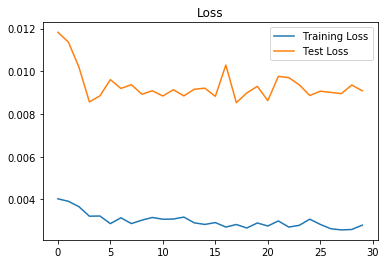

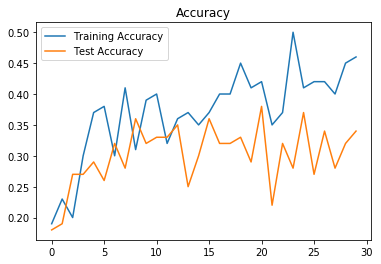

In [20]:
method = 'single'
num_epochs = 30
color = False
random_sample = True
skip = True
save_name = 'single_rand_skip_nocol'
# best LR: .0001
# best weight_decay: .005

base_path = 'VideoData/'
num_epochs = 30
torch.set_default_tensor_type('torch.FloatTensor')
# best LR: .0001
# best weight_decay: .005
# best weight_decay: .005
paths = os.listdir(base_path)
labels = [re.findall('_([^_]*)_', datastr)[0] for datastr in paths]
x = list(set(labels))
dic = dict(zip(x, list(range(0,len(x)))))
if color:
    input_features = 3
else:
    input_features = 1
    
if method == 'single':
    timesteps_vid = 1
    timesteps_net = 1
    net = VidNet(method,6,input_features*timesteps_net,timesteps_vid,timesteps_vid)
elif method=='conv_pool':
    timesteps_vid = 16
    timesteps_net = 16
    net = VidNet(method,6,input_features*timesteps_net,1,timesteps_vid)
elif method == 'late':
    timesteps_vid = 4
    timesteps_net = 1
    net = VidNet(method,6,input_features*timesteps_net,timesteps_vid,timesteps_vid)
elif method == 'slow':
    timesteps_vid = 16
    timesteps_net = 4
    net = VidNet(method,6,input_features*timesteps_net,1,timesteps_vid)
else:
    print('define valid method')
if load:
    net.load_state_dict(torch.load(save_name + '.pt'))
    net.cuda()
    print(next(net.parameters()).is_cuda)
#     for statet in net.state.values():
#         for h,g in statet.items():
#             if torch.is_tensor(g):
#                 statet[h] = g.cuda()
    optimize = optim.Adam(net.parameters(), lr = 0.0001, weight_decay = .005)
    optimize.load_state_dict(torch.load(save_name + '_opt.pt'))
    for state in optimize.state.values():
        for k, v in state.items():
            if torch.is_tensor(v):
                state[k] = v.cuda()
else:
    optimize = optim.Adam(net.parameters(), lr = 0.0001, weight_decay = .005)
#     net.cuda()
crit = nn.CrossEntropyLoss()
#(self,net,train_path,test_path,vid_path,epochs,optimizer,criterion)
tr = Trainer(net,dic,base_path,timesteps_vid,num_epochs,optimize,crit,10,color,
                random_sample,skip)
trl,tstl,tra,tsta = tr.run_epochs(save_name)

plt.figure()
plt.plot(range(num_epochs),trl,label= 'Training Loss')
plt.plot(range(num_epochs),tstl,label= 'Test Loss')
plt.legend()
plt.title('Loss')
plt.show()

plt.figure()
plt.plot(range(num_epochs),tra,label= 'Training Accuracy')
plt.plot(range(num_epochs),tsta,label= 'Test Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

/Users/jenniferdawkins/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 0:  Train Loss: [0.0039524348913163015]; Test Loss: [0.011957253694534303]
Epoch 0:  Train Accuracy: [0.19]; Test Accuracy: [0.17]
Epoch 1:  Train Loss: [0.0037463310566670646]; Test Loss: [0.011290279706319174]
Epoch 1:  Train Accuracy: [0.25]; Test Accuracy: [0.17]
Epoch 2:  Train Loss: [0.003496921673118404]; Test Loss: [0.010675081570943197]
Epoch 2:  Train Accuracy: [0.28]; Test Accuracy: [0.32]
Epoch 3:  Train Loss: [0.0029357702270116997]; Test Loss: [0.009974331617355347]
Epoch 3:  Train Accuracy: [0.39]; Test Accuracy: [0.35]
Epoch 4:  Train Loss: [0.0026376458743632768]; Test Loss: [0.009149869441986085]
Epoch 4:  Train Accuracy: [0.44]; Test Accuracy: [0.31]
Epoch 5:  Train Loss: [0.0027709196166100106]; Test Loss: [0.010070919632911682]
Epoch 5:  Train Accuracy: [0.36]; Test Accuracy: [0.35]
Epoch 6:  Train Loss: [0.002539635315238766]; Test Loss: [0.011113372246424356]
Epoch 6:  Train Accuracy: [0.39]; Test Accuracy: [0.32]
Epoch 7:  Train Loss: [0.002568583578734196

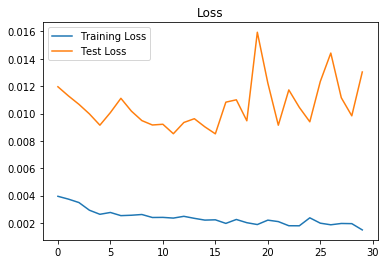

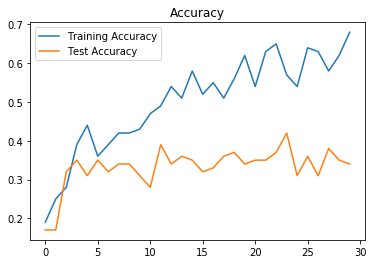

In [4]:
load = False
method = 'conv_pool'
num_epochs = 30
color = False
random_sample = False
skip = True
save_name = 'conv_norand_skip'
# best LR: .0001
# best weight_decay: .005

base_path = 'VideoData/'
num_epochs = 30
torch.set_default_tensor_type('torch.FloatTensor')
# best LR: .0001
# best weight_decay: .005
# best weight_decay: .005
paths = os.listdir(base_path)
labels = [re.findall('_([^_]*)_', datastr)[0] for datastr in paths]
x = list(set(labels))
dic = dict(zip(x, list(range(0,len(x)))))
if color:
    input_features = 3
else:
    input_features = 1
    
if method == 'single':
    timesteps_vid = 1
    timesteps_net = 1
    net = VidNet(method,6,input_features*timesteps_net,timesteps_vid,timesteps_vid)
elif method=='conv_pool':
    timesteps_vid = 16
    timesteps_net = 16
    net = VidNet(method,6,input_features*timesteps_net,1,timesteps_vid)
elif method == 'late':
    timesteps_vid = 4
    timesteps_net = 1
    net = VidNet(method,6,input_features*timesteps_net,timesteps_vid,timesteps_vid)
elif method == 'slow':
    timesteps_vid = 16
    timesteps_net = 4
    net = VidNet(method,6,input_features*timesteps_net,1,timesteps_vid)
else:
    print('define valid method')
if load:
    net.load_state_dict(torch.load(save_name + '.pt'))
    net.cuda()
    print(next(net.parameters()).is_cuda)
#     for statet in net.state.values():
#         for h,g in statet.items():
#             if torch.is_tensor(g):
#                 statet[h] = g.cuda()
    optimize = optim.Adam(net.parameters(), lr = 0.0001, weight_decay = .005)
    optimize.load_state_dict(torch.load(save_name + '_opt.pt'))
    for state in optimize.state.values():
        for k, v in state.items():
            if torch.is_tensor(v):
                state[k] = v.cuda()
else:
    optimize = optim.Adam(net.parameters(), lr = 0.0001, weight_decay = .005)
#     net.cuda()
crit = nn.CrossEntropyLoss()
#(self,net,train_path,test_path,vid_path,epochs,optimizer,criterion)
tr = Trainer(net,dic,base_path,timesteps_vid,num_epochs,optimize,crit,10,color,
                random_sample,skip)
trl,tstl,tra,tsta = tr.run_epochs(save_name)

plt.figure()
plt.plot(range(num_epochs),trl,label= 'Training Loss')
plt.plot(range(num_epochs),tstl,label= 'Test Loss')
plt.legend()
plt.title('Loss')
plt.show()

plt.figure()
plt.plot(range(num_epochs),tra,label= 'Training Accuracy')
plt.plot(range(num_epochs),tsta,label= 'Test Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

/Users/jenniferdawkins/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 0:  Train Loss: [0.0038955535017833414]; Test Loss: [0.012192195892333984]
Epoch 0:  Train Accuracy: [0.22]; Test Accuracy: [0.17]
Epoch 1:  Train Loss: [0.0036849648490514947]; Test Loss: [0.011315533479054769]
Epoch 1:  Train Accuracy: [0.21]; Test Accuracy: [0.22]
Epoch 2:  Train Loss: [0.0033156853210687108]; Test Loss: [0.012029435714085896]
Epoch 2:  Train Accuracy: [0.33]; Test Accuracy: [0.35]
Epoch 3:  Train Loss: [0.0030227265804010405]; Test Loss: [0.012195503075917562]
Epoch 3:  Train Accuracy: [0.35]; Test Accuracy: [0.35]
Epoch 4:  Train Loss: [0.0026771331152034496]; Test Loss: [0.007883646925290425]
Epoch 4:  Train Accuracy: [0.39]; Test Accuracy: [0.41]
Epoch 5:  Train Loss: [0.002562657297321311]; Test Loss: [0.008085306326548258]
Epoch 5:  Train Accuracy: [0.37]; Test Accuracy: [0.31]
Epoch 6:  Train Loss: [0.002354989524408013]; Test Loss: [0.008911598205566407]
Epoch 6:  Train Accuracy: [0.45]; Test Accuracy: [0.38]
Epoch 7:  Train Loss: [0.002605082370125106

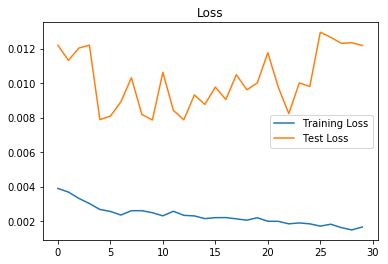

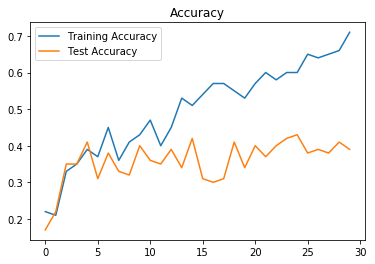

In [5]:
load = False
method = 'late'
num_epochs = 30
color = False
random_sample = False
skip = True
save_name = 'late_norand_skip'
base_path = 'VideoData/'
num_epochs = 30
torch.set_default_tensor_type('torch.FloatTensor')
# best LR: .0001
# best weight_decay: .005
# best weight_decay: .005
paths = os.listdir(base_path)
labels = [re.findall('_([^_]*)_', datastr)[0] for datastr in paths]
x = list(set(labels))
dic = dict(zip(x, list(range(0,len(x)))))
if color:
    input_features = 3
else:
    input_features = 1
    
if method == 'single':
    timesteps_vid = 1
    timesteps_net = 1
    net = VidNet(method,6,input_features*timesteps_net,timesteps_vid,timesteps_vid)
elif method=='conv_pool':
    timesteps_vid = 16
    timesteps_net = 16
    net = VidNet(method,6,input_features*timesteps_net,1,timesteps_vid)
elif method == 'late':
    timesteps_vid = 4
    timesteps_net = 1
    net = VidNet(method,6,input_features*timesteps_net,timesteps_vid,timesteps_vid)
elif method == 'slow':
    timesteps_vid = 16
    timesteps_net = 4
    net = VidNet(method,6,input_features*timesteps_net,1,timesteps_vid)
else:
    print('define valid method')
if load:
    net.load_state_dict(torch.load(save_name + '.pt'))
    net.cuda()
    print(next(net.parameters()).is_cuda)
#     for statet in net.state.values():
#         for h,g in statet.items():
#             if torch.is_tensor(g):
#                 statet[h] = g.cuda()
    optimize = optim.Adam(net.parameters(), lr = 0.0001, weight_decay = .005)
    optimize.load_state_dict(torch.load(save_name + '_opt.pt'))
    for state in optimize.state.values():
        for k, v in state.items():
            if torch.is_tensor(v):
                state[k] = v.cuda()
else:
    optimize = optim.Adam(net.parameters(), lr = 0.0001, weight_decay = .005)
#     net.cuda()
crit = nn.CrossEntropyLoss()
#(self,net,train_path,test_path,vid_path,epochs,optimizer,criterion)
tr = Trainer(net,dic,base_path,timesteps_vid,num_epochs,optimize,crit,10,color,
                random_sample,skip)
trl,tstl,tra,tsta = tr.run_epochs(save_name)

plt.figure()
plt.plot(range(num_epochs),trl,label= 'Training Loss')
plt.plot(range(num_epochs),tstl,label= 'Test Loss')
plt.legend()
plt.title('Loss')
plt.show()

plt.figure()
plt.plot(range(num_epochs),tra,label= 'Training Accuracy')
plt.plot(range(num_epochs),tsta,label= 'Test Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

/Users/jenniferdawkins/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 0:  Train Loss: [0.003993822391951801]; Test Loss: [0.011816414912541708]
Epoch 0:  Train Accuracy: [0.25]; Test Accuracy: [0.17]
Epoch 1:  Train Loss: [0.003769862864224576]; Test Loss: [0.011581112066904705]
Epoch 1:  Train Accuracy: [0.25]; Test Accuracy: [0.17]
Epoch 2:  Train Loss: [0.0034262519636770136]; Test Loss: [0.011010552008946736]
Epoch 2:  Train Accuracy: [0.26]; Test Accuracy: [0.26]
Epoch 3:  Train Loss: [0.0030391974544737546]; Test Loss: [0.010198656717936199]
Epoch 3:  Train Accuracy: [0.35]; Test Accuracy: [0.36]
Epoch 4:  Train Loss: [0.002755913198126982]; Test Loss: [0.010582212924957275]
Epoch 4:  Train Accuracy: [0.34]; Test Accuracy: [0.37]
Epoch 5:  Train Loss: [0.0027068027143754515]; Test Loss: [0.009581270615259806]
Epoch 5:  Train Accuracy: [0.36]; Test Accuracy: [0.31]
Epoch 6:  Train Loss: [0.0025714541331165884]; Test Loss: [0.008668697913487752]
Epoch 6:  Train Accuracy: [0.43]; Test Accuracy: [0.35]
Epoch 7:  Train Loss: [0.002513990795160986]

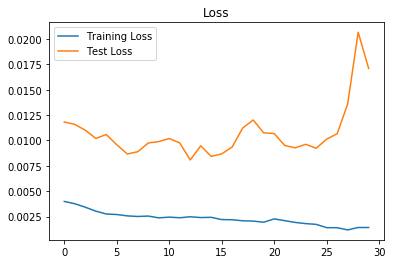

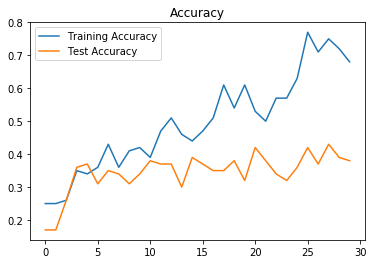

In [6]:
load = False
method = 'slow'
num_epochs = 30
color = False
random_sample = False
skip = True
save_name = 'slow_norand_skip'
base_path = 'VideoData/'
num_epochs = 30
torch.set_default_tensor_type('torch.FloatTensor')
# best LR: .0001
# best weight_decay: .005
# best weight_decay: .005
paths = os.listdir(base_path)
labels = [re.findall('_([^_]*)_', datastr)[0] for datastr in paths]
x = list(set(labels))
dic = dict(zip(x, list(range(0,len(x)))))
if color:
    input_features = 3
else:
    input_features = 1
    
if method == 'single':
    timesteps_vid = 1
    timesteps_net = 1
    net = VidNet(method,6,input_features*timesteps_net,timesteps_vid,timesteps_vid)
elif method=='conv_pool':
    timesteps_vid = 16
    timesteps_net = 16
    net = VidNet(method,6,input_features*timesteps_net,1,timesteps_vid)
elif method == 'late':
    timesteps_vid = 4
    timesteps_net = 1
    net = VidNet(method,6,input_features*timesteps_net,timesteps_vid,timesteps_vid)
elif method == 'slow':
    timesteps_vid = 16
    timesteps_net = 4
    net = VidNet(method,6,input_features*timesteps_net,1,timesteps_vid)
else:
    print('define valid method')
if load:
    net.load_state_dict(torch.load(save_name + '.pt'))
    net.cuda()
    print(next(net.parameters()).is_cuda)
#     for statet in net.state.values():
#         for h,g in statet.items():
#             if torch.is_tensor(g):
#                 statet[h] = g.cuda()
    optimize = optim.Adam(net.parameters(), lr = 0.0001, weight_decay = .005)
    optimize.load_state_dict(torch.load(save_name + '_opt.pt'))
    for state in optimize.state.values():
        for k, v in state.items():
            if torch.is_tensor(v):
                state[k] = v.cuda()
else:
    optimize = optim.Adam(net.parameters(), lr = 0.0001, weight_decay = .005)
#     net.cuda()
crit = nn.CrossEntropyLoss()
#(self,net,train_path,test_path,vid_path,epochs,optimizer,criterion)
tr = Trainer(net,dic,base_path,timesteps_vid,num_epochs,optimize,crit,10,color,
                random_sample,skip)
trl,tstl,tra,tsta = tr.run_epochs(save_name)

plt.figure()
plt.plot(range(num_epochs),trl,label= 'Training Loss')
plt.plot(range(num_epochs),tstl,label= 'Test Loss')
plt.legend()
plt.title('Loss')
plt.show()

plt.figure()
plt.plot(range(num_epochs),tra,label= 'Training Accuracy')
plt.plot(range(num_epochs),tsta,label= 'Test Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

/Users/jenniferdawkins/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 0:  Train Loss: [0.003987109209753092]; Test Loss: [0.01194826594988505]
Epoch 0:  Train Accuracy: [0.19]; Test Accuracy: [0.17]
Epoch 1:  Train Loss: [0.0037989118316922262]; Test Loss: [0.011426988045374552]
Epoch 1:  Train Accuracy: [0.25]; Test Accuracy: [0.17]
Epoch 2:  Train Loss: [0.0034520232597809856]; Test Loss: [0.011224734624226889]
Epoch 2:  Train Accuracy: [0.26]; Test Accuracy: [0.28]
Epoch 3:  Train Loss: [0.0031290771435523086]; Test Loss: [0.011976351499557496]
Epoch 3:  Train Accuracy: [0.35]; Test Accuracy: [0.37]
Epoch 4:  Train Loss: [0.0028469178352695797]; Test Loss: [0.010151681264241538]
Epoch 4:  Train Accuracy: [0.27]; Test Accuracy: [0.31]
Epoch 5:  Train Loss: [0.002470995124039512]; Test Loss: [0.009431575139363607]
Epoch 5:  Train Accuracy: [0.43]; Test Accuracy: [0.38]
Epoch 6:  Train Loss: [0.00267311815164137]; Test Loss: [0.009575412034988403]
Epoch 6:  Train Accuracy: [0.46]; Test Accuracy: [0.4]
Epoch 7:  Train Loss: [0.0026062836360294197]; 

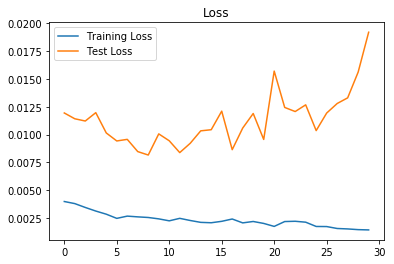

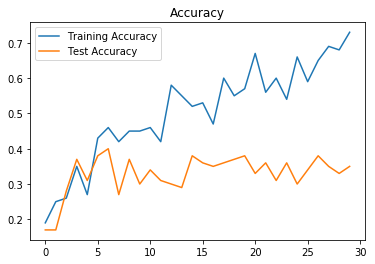

In [7]:
load = False
method = 'conv_pool'
num_epochs = 30
color = False
random_sample = False
skip = True
save_name = 'conv_norand_skip'
base_path = 'VideoData/'
num_epochs = 30
torch.set_default_tensor_type('torch.FloatTensor')
# best LR: .0001
# best weight_decay: .005
# best weight_decay: .005
paths = os.listdir(base_path)
labels = [re.findall('_([^_]*)_', datastr)[0] for datastr in paths]
x = list(set(labels))
dic = dict(zip(x, list(range(0,len(x)))))
if color:
    input_features = 3
else:
    input_features = 1
    
if method == 'single':
    timesteps_vid = 1
    timesteps_net = 1
    net = VidNet(method,6,input_features*timesteps_net,timesteps_vid,timesteps_vid)
elif method=='conv_pool':
    timesteps_vid = 16
    timesteps_net = 16
    net = VidNet(method,6,input_features*timesteps_net,1,timesteps_vid)
elif method == 'late':
    timesteps_vid = 4
    timesteps_net = 1
    net = VidNet(method,6,input_features*timesteps_net,timesteps_vid,timesteps_vid)
elif method == 'slow':
    timesteps_vid = 16
    timesteps_net = 4
    net = VidNet(method,6,input_features*timesteps_net,1,timesteps_vid)
else:
    print('define valid method')
if load:
    net.load_state_dict(torch.load(save_name + '.pt'))
    net.cuda()
    print(next(net.parameters()).is_cuda)
#     for statet in net.state.values():
#         for h,g in statet.items():
#             if torch.is_tensor(g):
#                 statet[h] = g.cuda()
    optimize = optim.Adam(net.parameters(), lr = 0.0001, weight_decay = .005)
    optimize.load_state_dict(torch.load(save_name + '_opt.pt'))
    for state in optimize.state.values():
        for k, v in state.items():
            if torch.is_tensor(v):
                state[k] = v.cuda()
else:
    optimize = optim.Adam(net.parameters(), lr = 0.0001, weight_decay = .005)
#     net.cuda()
crit = nn.CrossEntropyLoss()
#(self,net,train_path,test_path,vid_path,epochs,optimizer,criterion)
tr = Trainer(net,dic,base_path,timesteps_vid,num_epochs,optimize,crit,10,color,
                random_sample,skip)
trl,tstl,tra,tsta = tr.run_epochs(save_name)

plt.figure()
plt.plot(range(num_epochs),trl,label= 'Training Loss')
plt.plot(range(num_epochs),tstl,label= 'Test Loss')
plt.legend()
plt.title('Loss')
plt.show()

plt.figure()
plt.plot(range(num_epochs),tra,label= 'Training Accuracy')
plt.plot(range(num_epochs),tsta,label= 'Test Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

/Users/jenniferdawkins/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 0:  Train Loss: [0.003921154586137801]; Test Loss: [0.011953545014063517]
Epoch 0:  Train Accuracy: [0.2]; Test Accuracy: [0.17]
Epoch 1:  Train Loss: [0.003663645077388908]; Test Loss: [0.01093610143661499]
Epoch 1:  Train Accuracy: [0.24]; Test Accuracy: [0.17]
Epoch 2:  Train Loss: [0.0033472980582103435]; Test Loss: [0.010987442334493001]
Epoch 2:  Train Accuracy: [0.3]; Test Accuracy: [0.3]
Epoch 3:  Train Loss: [0.0029404839587901907]; Test Loss: [0.01009987195332845]
Epoch 3:  Train Accuracy: [0.41]; Test Accuracy: [0.35]
Epoch 4:  Train Loss: [0.002858706253408589]; Test Loss: [0.009953287283579509]
Epoch 4:  Train Accuracy: [0.27]; Test Accuracy: [0.32]
Epoch 5:  Train Loss: [0.002590211860852146]; Test Loss: [0.008883723815282187]
Epoch 5:  Train Accuracy: [0.38]; Test Accuracy: [0.35]
Epoch 6:  Train Loss: [0.0025362017425503126]; Test Loss: [0.009971806128819784]
Epoch 6:  Train Accuracy: [0.38]; Test Accuracy: [0.27]
Epoch 7:  Train Loss: [0.0027246817714121933]; Tes

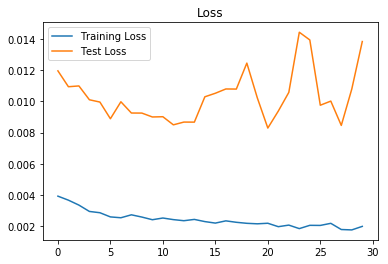

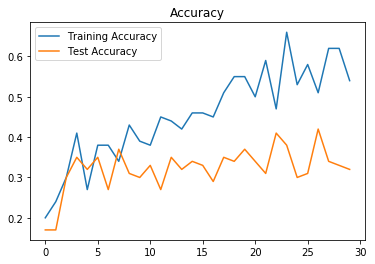

In [8]:
load = False
method = 'single'
num_epochs = 30
color = False
random_sample = False
skip = True
save_name = 'single_norand_skip'
base_path = 'VideoData/'
num_epochs = 30
torch.set_default_tensor_type('torch.FloatTensor')
# best LR: .0001
# best weight_decay: .005
# best weight_decay: .005
paths = os.listdir(base_path)
labels = [re.findall('_([^_]*)_', datastr)[0] for datastr in paths]
x = list(set(labels))
dic = dict(zip(x, list(range(0,len(x)))))
if color:
    input_features = 3
else:
    input_features = 1
    
if method == 'single':
    timesteps_vid = 1
    timesteps_net = 1
    net = VidNet(method,6,input_features*timesteps_net,timesteps_vid,timesteps_vid)
elif method=='conv_pool':
    timesteps_vid = 16
    timesteps_net = 16
    net = VidNet(method,6,input_features*timesteps_net,1,timesteps_vid)
elif method == 'late':
    timesteps_vid = 4
    timesteps_net = 1
    net = VidNet(method,6,input_features*timesteps_net,timesteps_vid,timesteps_vid)
elif method == 'slow':
    timesteps_vid = 16
    timesteps_net = 4
    net = VidNet(method,6,input_features*timesteps_net,1,timesteps_vid)
else:
    print('define valid method')
if load:
    net.load_state_dict(torch.load(save_name + '.pt'))
    net.cuda()
    print(next(net.parameters()).is_cuda)
#     for statet in net.state.values():
#         for h,g in statet.items():
#             if torch.is_tensor(g):
#                 statet[h] = g.cuda()
    optimize = optim.Adam(net.parameters(), lr = 0.0001, weight_decay = .005)
    optimize.load_state_dict(torch.load(save_name + '_opt.pt'))
    for state in optimize.state.values():
        for k, v in state.items():
            if torch.is_tensor(v):
                state[k] = v.cuda()
else:
    optimize = optim.Adam(net.parameters(), lr = 0.0001, weight_decay = .005)
#     net.cuda()
crit = nn.CrossEntropyLoss()
#(self,net,train_path,test_path,vid_path,epochs,optimizer,criterion)
tr = Trainer(net,dic,base_path,timesteps_vid,num_epochs,optimize,crit,10,color,
                random_sample,skip)
trl,tstl,tra,tsta = tr.run_epochs(save_name)

plt.figure()
plt.plot(range(num_epochs),trl,label= 'Training Loss')
plt.plot(range(num_epochs),tstl,label= 'Test Loss')
plt.legend()
plt.title('Loss')
plt.show()

plt.figure()
plt.plot(range(num_epochs),tra,label= 'Training Accuracy')
plt.plot(range(num_epochs),tsta,label= 'Test Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()